In [1]:
import numpy as np
import pandas as pd
import quandl, math, datetime
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import IPython
import pickle

## Load Google stock data

In [2]:
df = quandl.get('WIKI/GOOGL')
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [3]:
# Optional: Save on local disk for future use
# df.to_csv(r'D:\Amol-3D\study\Data Science\DSN-70days\data.csv')

In [4]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


## Data wrangling

#### Create new columns

In [5]:
df['HL_PCT'] = df['Adj. High'] - df['Adj. Close'] / df['Adj. Close'] * 100
df['PCT_Change'] = df['Adj. Close'] - df['Adj. Open'] / df['Adj. Open'] * 100
df.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,HL_PCT,PCT_Change
Date,,,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0,-47.808891,-49.677158
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0,-45.291119,-45.677311
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0,-43.084307,-45.130623
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0,-44.027217,-47.402637
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0,-45.832791,-46.835887


In [6]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_Change', 'Adj. Volume']]
df.head()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
Date,,,,
2004-08-19,50.322842,-47.808891,-49.677158,44659000.0
2004-08-20,54.322689,-45.291119,-45.677311,22834300.0
2004-08-23,54.869377,-43.084307,-45.130623,18256100.0
2004-08-24,52.597363,-44.027217,-47.402637,15247300.0
2004-08-25,53.164113,-45.832791,-46.835887,9188600.0


#### Handle missing data

In [7]:
# Replace NANs with an outlier value
df.fillna(-99999, inplace=True)

#### Visualize the data (to determine if linear regression is valid approach, which is only if there is existing linear relation)

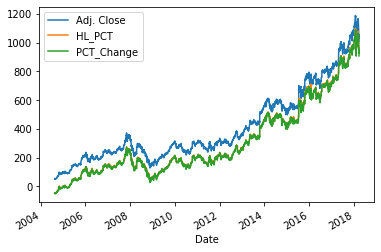

In [8]:
df[['Adj. Close', 'HL_PCT', 'PCT_Change']].plot()
plt.show()

## Feature Engineering


In [9]:
# Define forcast label
forecast_col = 'Adj. Close'
forecast_out = int(math.ceil(0.01 * len(df)))  # these are the number of days in future for which we will predict the stock

In [10]:
df['label'] = df[forecast_col].shift(-forecast_out)

# We do NOT drop the last rows which are now NaN because we shifted the df.
# BECAUSE we need them for predictions

## Regression Model

#### Set the features 'X' and label 'y'

In [11]:
X = np.array(df.drop('label', axis=1))
y = np.array(df.label.dropna())

#### Preprocess the data/scale the features BEFORE splitting it into training and test sets and BEFORE we skip the data for which y values are NaN due to shifting the df

In [12]:
X = preprocessing.scale(X)

#### Skip the data for which y values are NaN (Null values are present beacuse we have shifted the df) If we skip these values before preprocessing the data, the scaling would be incorrect due to missing values of X

In [13]:
X_for_predictions = X[-forecast_out:]    # data for which we will predict the y values
X = X[:-forecast_out]    # skip the data for which y values are NaN. This is beacuse we have shifted the df

#### Separate training and testing data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Create a classifier based on Linear Regression

In [15]:
clf = LinearRegression(n_jobs=-1)

#### Fit the classifier for training data

In [16]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

#### Pickle the trained classifier for future use - this will enable us to have pre-trained model every time we run the prediction, avoiding repetative trainings

In [17]:
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

#### Calculate the accuracy of classifier using test data

In [18]:
accuracy = clf.score(X_test, y_test)
accuracy

0.9745649138354027

## Predictions using the model

In [19]:
predictions = clf.predict(X_for_predictions)
print(f'Predictions: \n{predictions} \nAccuracy: {accuracy} \nPredicted no. of days in future: {forecast_out}')

Predictions: 
[1102.58351765 1073.08845855 1021.94509072 1060.80345038 1072.6343682
 1072.81090695 1091.45413757 1110.36917037 1114.22363836 1122.52036404
 1132.36820675 1128.92003335 1147.69958054 1163.35144324 1136.02406146
 1122.25365517 1088.91655767 1102.79816617 1113.85941223 1120.20343134
 1134.40541573 1148.85868451 1180.4109743  1185.21706175 1158.31909931
 1168.10212487 1169.97949117 1152.96132702 1118.21704216 1114.30090845
 1112.6553513  1070.45936871 1043.80147534 1072.11183191 1023.36690906] 
Accuracy: 0.9745649138354027 
Predicted no. of days in future: 35


## Visualize the predicted data

In [20]:
style.use('ggplot')

In [21]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in predictions:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]


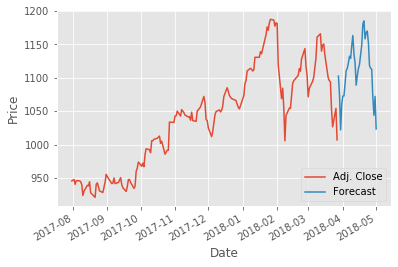

In [22]:
df['Adj. Close'].iloc[-200:].plot()
df['Forecast'].iloc[-200:].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()